# Classify Emails beyond spams - using K-Means Clustering

### This notebook shows the implementation of K-Means clustering WSD i.e. Word Sense Disambiguation. The synonyms have been included here. Level 2

### Final Project - Riti Chakraborty¶

In [1]:
#Riti Chakraborty

#importing the required libraries
import scipy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
#library for tf-idf vector
from sklearn.feature_extraction.text import TfidfVectorizer


import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import CountVectorizer
import numpy
from numpy import nan

#for flattening lists
from itertools import chain

#To handle warning
import warnings
warnings.filterwarnings('ignore')

#For implementing Natural Language Processing approaches.
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

#For using Regular expression
import re

#For Handling Strings
import string
#For plotting data
import matplotlib.pyplot as plt


#For implementing word sense disambiguation
from nltk.corpus import wordnet as wn
from wordsegment import load, segment

#Important to call load()
load()

#Importing Libraries required for arithmatic operations
from operator import mul 
from operator import add

#For LDA Implementation # Importing Gensim
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
from gensim import corpora

#For evaluation Topic models formed
from gensim.models import CoherenceModel

#For visualising LDA Output
import pyLDAvis
import pyLDAvis.gensim 

In [2]:
#This file read here, has been generated by the data_preprocess.ipynb.
data_subset=pd.read_csv("../exported_tables/data_subset.csv")

#converting the data in the dataframe into str type
data_subset = data_subset.astype(str) 

#retaining proper index
data_subset=data_subset.reset_index(drop=True)

num_of_rows=len(data_subset.index)
print("Total Number of rows: ",num_of_rows)

#Email data


# Converting each row to list of lists
list1=data_subset.values.tolist()
list2=[]

# Converting each sublist into string and storing it in list2
for i in range(0, len(list1)):
    list2.append(' '.join(map(str, list1[i])))


Total Number of rows:  1135


### Function for Stop words removal

In [3]:
def stopword_remove(l2):
    fil_list2=[]
    for sent in l2:
        stop_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours","hibody", "yourself", "spam","body","yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
        word_tokens = word_tokenize(sent.lower())
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        filtered_sentence = []

        for w in word_tokens:
            if w not in stop_words:
                filtered_sentence.append(w)

        fil_list2.append(' '.join(filtered_sentence))
    return fil_list2
#     print()

#calling the Stopword_remove function and the storing the results returned in a list
fil_list2=stopword_remove(list2)
# print(fil_list2)


### Function for Punctuation Removal

In [4]:
# Defining a function to remove punctuation
def no_punctuation(my_str):
    punctuations = '''!()-[]{};:'"\\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char
        else:
            no_punct = no_punct + " "
    return no_punct

### Function for Segementing words and fetching synonyms

In [5]:
def seg_syn(l1):
    wordlist2=[]
    wordlist2.append(no_punctuation(l1).split())
    seg=[]
    for w in wordlist2:
        #Removing Integers
        no_integers = [x for x in w if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
        pure_string=[x for x in no_integers if not any(c.isdigit() for c in x)]
        
        #Word segmentation
        for s in pure_string:
            seg.append(segment(s))
            
    #flattening the list
    flat_seg_list = [item for sublist in seg for item in sublist]
    
    #Creating a dictionary to store the synonyms and hypernyms
    d = {'Term':[], 'Synonyms':[], 'Hypernyms':[]}
    d1={}
    
    #List for storing Synonyms
    syn0=[]
    
    #List for storing hypernyms
    hyp0=[]
    
    #Fetching synonyms and hypernyms from the wornet API
    for f in flat_seg_list:
        d['Term'].append(f)        
        for syn in wn.synsets(f):
            synsets=syn
            
            #Synonyms Part
            for l in syn.lemmas():
                syn0.append(l.name())

    return syn0


In [6]:
# Calling the function seg_syn()
list2_syn=[]
for l in fil_list2:
    #Storing the synonyms and the hypernyms part returned from the previous function
    syno=seg_syn(str(l))
    list2_syn.append(syno)


#flattening
flat_list_syn=len(list(chain(*list2_syn)))


#Converting back to strings
flat_list2_syn=[]
for ls in list2_syn:
    flat_list2_syn.append(' '.join(list(set(ls))))

#Storing the values as a dataframe
df_flatlist=pd.DataFrame(flat_list2_syn)
df_flatlist["Index"]=df_flatlist.index

#removing the punctuation marks
no_punct_flat_list2_syn=[no_punctuation(i) for i in flat_list2_syn]


# K-Means Clustering - Unsupervised Approach


In [7]:
#genrating the tf-idf matrix
vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)

#here X is in the form of ndarray
X = vect.fit_transform(no_punct_flat_list2_syn)

#Terms in overall dataset
terms = vect.get_feature_names()

#For computing distances between data points
distance_cos = 1 - cosine_similarity(X)


### Using PCA for Visualising the spread of data points
Note: PCA has been used only for the visualisation purpose.

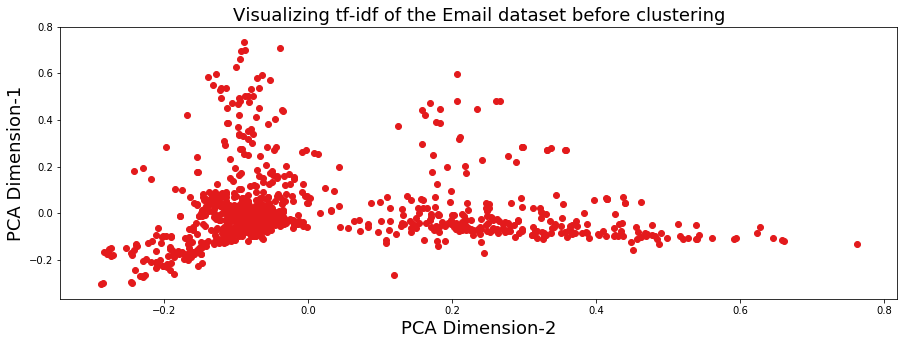

In [8]:
random.seed(3425)


X_matrix=X.todense()
X_matrix.shape

#Setting size for the plot figure
plt.rc('figure', figsize=(15, 5))

#converting tf idf ndarray to matrix form 
X_dense = X.todense()

coordinates = PCA(n_components=2).fit_transform(X_dense)

plt.scatter(coordinates[:, 0], coordinates[:, 1], c='#e31a1c')
plt.title("Visualizing tf-idf of the Email dataset before clustering",fontsize=18)
plt.xlabel('PCA Dimension-2', fontsize=18)
plt.ylabel('PCA Dimension-1', fontsize=18)
plt.savefig('../results_dendrograms_kmeans_visualisation/kmeansL2.jpg')
plt.show()

### Approaches used in determining the Right k i.e. no. of Clusters.
1. Elbow method
2. Silhouette Coefficient

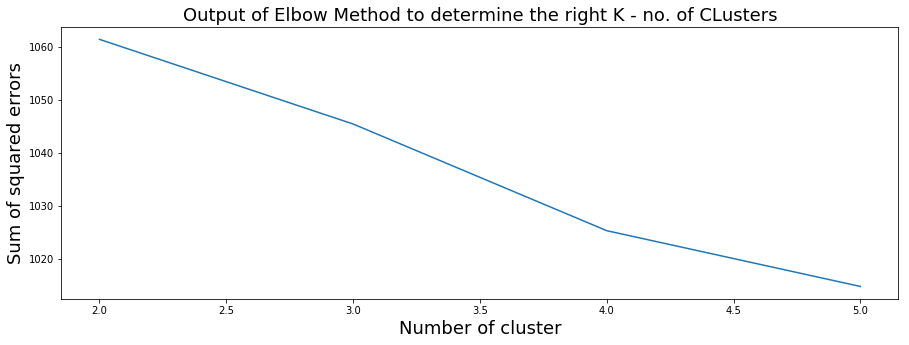

In [9]:

#Setting a random seed.
#this is basically because kmeans start by chosing random centroid that would give different results at each run. In order to avoid that and
#generate consistent outputs, random.seed or random_state is necessary.
random.seed(3425)

#Elbow Method
sum_squared_err = {}

#passing a range(2,6) of value for determining the optimal k 
#because (as observed in the graph below) there is no elbow formation from k=2 to k=5
for k in range(2, 6):
    
    # executing Kmeans in loop
    kmeans = KMeans(n_clusters=k, max_iter=500, random_state=3425).fit(X)
    
    #.inertia is used to find the sum of distances of samples to their closest cluster centroids i.e. sum of squared error
    sum_squared_err[k] = kmeans.inertia_ 
    
#Plotting the graph generated
plt.figure()
plt.plot(list(sum_squared_err.keys()), list(sum_squared_err.values()))
plt.title("Output of Elbow Method to determine the right K - no. of CLusters",fontsize=18)
plt.xlabel("Number of cluster", fontsize=18)
plt.ylabel("Sum of squared errors", fontsize=18)
plt.savefig('../results_dendrograms_kmeans_visualisation/elbow_kmeansL2.jpg')

In [10]:
random.seed(3425)

#Silhouette Coefficient
from sklearn.metrics import silhouette_score

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k,  max_iter=500, random_state=3425).fit(X)
    label = kmeans.labels_
    silhouette_coeff = silhouette_score(X, label, metric='euclidean')
    print(" The Silhouette Coefficient Calculated is = ",silhouette_coeff, " For K = ",k)

 The Silhouette Coefficient Calculated is =  0.02109153251699961  For K =  2
 The Silhouette Coefficient Calculated is =  0.024293627677366224  For K =  3
 The Silhouette Coefficient Calculated is =  0.029257067194597024  For K =  4
 The Silhouette Coefficient Calculated is =  0.0325469972013193  For K =  5


The optimal number of clusters returned by the above two method is 4 and 5 respectively. Silhouette method is more ambivalent in deciding the number of cluster. Therefore we proceed with k=4 as returned by the elbow method. HHowever, we can infer from the values returned by silhouette coefficient(which are near 0) that the clusters are very close to each other's boundary.

Ref: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html¶

### Defining K - Means Function

In [11]:
def k_means(no_of_cluster):
    n_clusters = no_of_cluster

    #Calling the function Kmeans from sklearn library    
    clf = KMeans(n_clusters=n_clusters, max_iter=500, init='k-means++', n_init=1, random_state=3425)
    

    #Storing fitted labels
    labels = clf.fit_predict(X)
    
    #Setting seed
    random.seed(3425)

    no_of_emails_in_current_cluster=[]
    for cl in range(0,n_clusters):
        no_of_emails_in_current_cluster.append(list(labels).count(cl))
    centroids = clf.cluster_centers_

    
    return centroids,labels,clf,no_of_emails_in_current_cluster

### Calling the k_means Function defined above 

In [12]:
#Calling k_means function
tuple_output=k_means(4)

#Segregating the values returned by the function and storing them in variables

#Labels
labels=tuple_output[1]

#classification model used for visualisation
clf=tuple_output[2]

#number of emails in each cluster
no_of_emails_in_cluster=tuple_output[3]

#Centroid
centroid_s=tuple_output[0]

#Transposing the Matrix for display purpose
centroids_transpose=centroid_s.transpose()

#The centroids of each cluster are a set of td-idf values of the terms.
#print(pd.DataFrame(centroids_transpose))

### Extracting Top n terms from each cluster.
here, top 5 terms from each cluster has been displayed

In [13]:
#converting centroid list to a dataframe
df_centroids_transpose=pd.DataFrame(centroids_transpose)

#adding the terms to its corresponding centroid values
df_centroids_transpose['terms']=terms

#finding the dimensions of the new dataframe with centroids and terms 
size_df_centroids_transpose=df_centroids_transpose.shape

#Finding out the top 5 terms from each cluster
no_of_cols=size_df_centroids_transpose[1]
no_of_cols
for i in range(0,(no_of_cols-1)):
    print("Top 5 terms in cluster number ", i)
    print(df_centroids_transpose.nlargest(5, i)['terms'])

Top 5 terms in cluster number  0
3947       net
4589    profit
5079      sack
3465      line
612       best
Name: terms, dtype: object
Top 5 terms in cluster number  1
5577     state
3544       low
5709    sunday
445     august
1485       day
Name: terms, dtype: object
Top 5 terms in cluster number  2
3588      mail
971      chain
5002      ring
363      armor
364     armour
Name: terms, dtype: object
Top 5 terms in cluster number  3
5507       speed
1547      degree
3448       light
391     ascorbic
949      celsius
Name: terms, dtype: object


# Visualising Kmeans Cluster using PCA


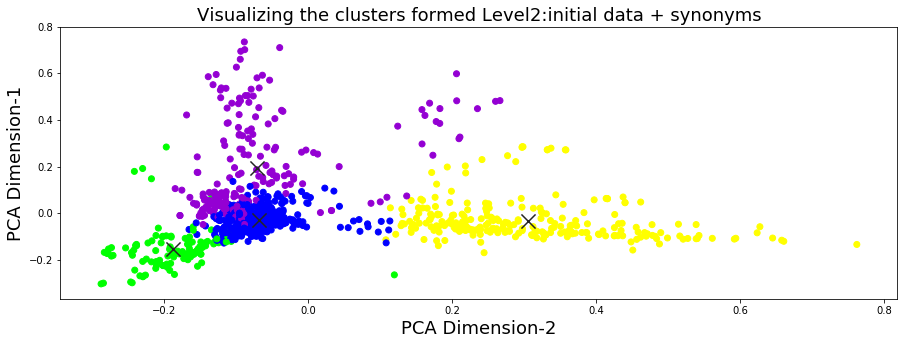

In [24]:
random.seed(1234)

pca = PCA(n_components=2).fit(X_dense)

#Defining a list of colors to be used in the visualisation. Different colour indicates different clusters
label_colors = ["#9400D3", "#0000FF", "#00FF00", "#FFFF00", "#FF7F00", "#FF0000",  "#4B0082","#FC6514"]

#Assigning distinct colors to the labels obtained
colors = [label_colors[i] for i in labels]

#Plotting the data
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=colors)

# Plot the cluster centers
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)


plt.scatter(centroid_coords[:, 0], centroid_coords[:, 1], marker='x', s=200, linewidths=1, c='#252525')
plt.title("Visualizing the clusters formed Level2:initial data + synonyms", fontsize=18)
plt.xlabel('PCA Dimension-2', fontsize=18)
plt.ylabel('PCA Dimension-1', fontsize=18)

#Exporting as image
plt.savefig('../results_dendrograms_kmeans_visualisation/kmeans_cls_L2.jpg')
plt.show()

### Precision, Recall and F-Value

In [15]:
#adding the labels returned by kmeans to each of the emails in the data_subset data frame.
data_subset=data_subset.reset_index(drop=True)
data_subset['labels_kmeans']=labels
data_subset=data_subset.sort_values('labels_kmeans')

#Renaming the dataframe
kmeans_result=data_subset
kmeans_clust = kmeans_result.groupby(by='labels_kmeans')

#grouping the emails depending on their labels
df_cluster_length=kmeans_result.groupby(['labels_kmeans']).size().to_frame(name = 'No_of_Emails_each_cluster').reset_index()
print(df_cluster_length)
#Grouping by cluster labels and Extracting Cluster types
cluster_types=len(df_cluster_length['labels_kmeans'].tolist())

   labels_kmeans  No_of_Emails_each_cluster
0              0                        214
1              1                        565
2              2                        112
3              3                        244


### Extracting Clusterwise data from the main data set

In [16]:
# Storing the Labels
kmeans_op = pd.DataFrame(labels)


#Performing join on the datsets
kmeans_result=kmeans_result.sort_values(by='labels_kmeans')

#Grouping by cluster labels
kmeans_clust = kmeans_result.groupby(kmeans_result['labels_kmeans'])


#Extracting Cluster types
cluster_types=list(set(kmeans_result['labels_kmeans']))
print("Cluster types:",cluster_types)

#Creating a list of Dataframes for each cluster
list_df_km=[]
for i in cluster_types:

#Displaying Clusterwise
    print("Cluster:", i)
    print()
    list_df_km.append(kmeans_clust.get_group(i))

Cluster types: [0, 1, 2, 3]
Cluster: 0

Cluster: 1

Cluster: 2

Cluster: 3



## Defining a function that would calculate the Precision, Recall and the F- Value

### Precision = number of emails having the term in a cluster / number of emails in the cluster

### Recall = number of emails having the term in a cluster / total number of emails having the term

### F- Measure /F-Value = 2[(precision recall) / (precision + recall)]

In [17]:
def function_PRF(Index):
    km_data_1=list_df_km[Index].values.tolist()
    
    #Precision denominator
    P_D=no_of_emails_in_cluster[Index]
    
    pre_pros_emails=[]
    k_updated=[]
    for k in km_data_1:
        remo_digit=[]
        for item in k:
            if type(item) == int:
                item=None
                remo_digit.append(item)
            else:
                remo_digit.append(item)

        #Filtering out None
        str_list = list(filter(None, remo_digit))

        #Removing Punctuation
        no_punct=[no_punctuation(str(i)) for i in str_list]

        #Tokenizing the strings
        split_str=list(chain(*[i.split() for i in no_punct]))

        #Word Segmentation
        seg_split_str=list(chain(*[segment(j) for j in split_str]))
    
        no_stop_word=stopword_remove(seg_split_str)

        #Removing words with length less than  or equal to 3
        clean_str=[(re.sub(r'\b\w{1,3}\b', '', c)) for c in no_stop_word]

        #Stripping Whitespace if any
        km_to_empty = [x.strip() for x in clean_str]
        km_clean_list = list([x for x in km_to_empty if x])

        #Storing
        k_updated.append(km_clean_list)

        #Calculating Frequency of Terms
        Term_freq_each_email = Counter(km_clean_list).most_common()



    #Calculating term freq in current cluster
    Term_freq=Counter(list(chain(*k_updated))).most_common()

    #Converting segmented emails into strings
    k_updated_emails=[' '.join(ka) for ka in k_updated]
    pre_pros_emails.append(k_updated_emails)


    #Extracting Terms from tuple
    terms_=[t[0] for t in Term_freq]

    ##################Calculating Precision and Recall##########################################
    numerator_P_R=[]
    recall_den=[]
    for t_ in terms_:
        count_email_with_a_term=0
        count_email_with_a_term_in_all_cluster=0

        #Number of Emails with term t in the current cluster
        for i in k_updated_emails:
            if t_ in i:
                count_email_with_a_term=count_email_with_a_term+1
        numerator_P_R.append(count_email_with_a_term)

        #Number of Emails with term t overall
        for f in flat_list2_syn:
            if t_ in f:
                count_email_with_a_term_in_all_cluster=count_email_with_a_term_in_all_cluster+1
        recall_den.append(count_email_with_a_term_in_all_cluster)

    
    recall=[(p*1.0)/(r or not r) for p,r in zip(numerator_P_R, recall_den)]

    
    P_num=np.array(numerator_P_R, dtype=np.float)
    P_den=np.array(P_D, dtype=np.float)

    precision_denominator=sum(P_num[0:len(P_num)])
    precision=list(np.nan_to_num(np.divide(P_num, precision_denominator)))

    ########################### F - Score ####################################

    #Calculating F-Score using formula (F=2*(P*R)/(P+R))    
    f_step1=[i*j for i,j in zip(precision,recall)]
    f_step2=[num*2 for num in f_step1]
    f_step3=list( map(add, precision, recall) )
    f_value=[(x*1.0)/y for x, y in zip(f_step2, f_step3)]
    
    #Dataframe with all values
    #Returning only the first five rows from the datadet conatining F-value, Precision and Recall
    P_R_F =pd.DataFrame({'Term': terms_, 'Precision': precision, 'Recall':recall, 'F-Value':f_value})
    return P_R_F.iloc[0:5,:],pre_pros_emails

### Calling the Precision and Recall Function defined above to display the F value

In [18]:
processed_cluster_data=[]
for ind in range(0,len(no_of_emails_in_cluster)):
    print("Cluster: ", ind)
    processed_cluster_data.append(function_PRF(ind)[1])
    print(function_PRF(ind)[0].sort_values('F-Value',  ascending=False))

Cluster:  0
    F-Value  Precision     Recall       Term
0  0.059764   0.029895  71.000000     viagra
2  0.031145   0.015579  37.000000      april
3  0.030303   0.015158  36.000000       july
4  0.028620   0.014316  34.000000  wednesday
1  0.026165   0.013474   0.450704       best
Cluster:  1
    F-Value  Precision     Recall       Term
1  0.029416   0.015033   0.680272     august
2  0.028859   0.014432  96.000000     friday
3  0.026454   0.013229  88.000000  september
4  0.025853   0.012928  86.000000  wednesday
0  0.018939   0.009471  63.000000    hotmail
Cluster:  2
    F-Value  Precision     Recall       Term
0  0.161509   0.091141   0.708609       mail
4  0.040851   0.020443  24.000000    tuesday
2  0.037850   0.021295   0.170068     august
1  0.032868   0.017036   0.465116  insurance
3  0.032340   0.016184  19.000000   facebook
Cluster:  3
    F-Value  Precision     Recall       Term
0  0.192975   0.108006   0.904762     mining
1  0.056818   0.028423  60.000000     viagra
2  0.04

### Data Preparation for LDA

In [19]:
random.seed(3425)
stop = set(stopwords.words('english'))
stop_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours","hibody", "yourself", "spam","body","yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
      
punct_1 = set(string.punctuation) 
lemma = WordNetLemmatizer()

def clean(doc):
    #Removing Stop words
    stop_removed = " ".join([i for i in doc.lower().split() if i not in stop_words])
    
    #removing Punctation
    punc_free = ''.join(i for i in stop_removed if i not in punct_1)
    
    #for stemming 
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    result = ''.join([i for i in normalized if not i.isdigit()])    
    return result

In [20]:
random.seed(3425)
#list conatining pre-processed data
pre_pros_list1=[]

#Flattening and storing it
for p in processed_cluster_data:
    pre_pros_list1.append(list(chain(*p)))

#Creation of dictionary
doc_clean = [clean(doc).split() for doc in  list(chain(*pre_pros_list1))] 
dictionary = gensim.corpora.Dictionary(doc_clean)

    # dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in doc_clean]
#
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=len(processed_cluster_data), id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(-1):
    print('\n Topic: {} \nWords: {}'.format(idx, topic))


 Topic: 0 
Words: 0.020*"hotmail" + 0.019*"thursday" + 0.015*"july" + 0.014*"monday" + 0.013*"september" + 0.012*"friday" + 0.012*"tuesday" + 0.010*"mail" + 0.010*"august" + 0.010*"sunday"

 Topic: 1 
Words: 0.018*"august" + 0.016*"monday" + 0.015*"friday" + 0.014*"viagra" + 0.014*"wednesday" + 0.013*"april" + 0.011*"mail" + 0.010*"pfizer" + 0.010*"free" + 0.010*"tuesday"

 Topic: 2 
Words: 0.084*"mining" + 0.022*"mail" + 0.018*"viagra" + 0.015*"july" + 0.015*"wednesday" + 0.015*"friday" + 0.014*"saturday" + 0.012*"sunday" + 0.011*"tuesday" + 0.011*"thursday"

 Topic: 3 
Words: 0.026*"mining" + 0.017*"september" + 0.016*"wednesday" + 0.013*"thursday" + 0.012*"tuesday" + 0.011*"saturday" + 0.011*"october" + 0.009*"sunday" + 0.007*"monday" + 0.007*"july"


### Computing Perplexity and Coherence to evaluate topic models formed

In [21]:

# Compute Perplexity : lowest perplexity is considered the best.
perplexity=lda_model.log_perplexity(bow_corpus)
print('\n Perplexity of the Spam Classification model: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Coherence Score of the Spam Classification model: ', coherence_lda)


 Perplexity of the Spam Classification model:  -7.309280150821474

 Coherence Score of the Spam Classification model:  0.3184524789382861


In [22]:
print("Kmeans LDA level 2")
pyLDAvis.enable_notebook()
id2word=dictionary
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, id2word)
vis

Kmeans LDA level 2


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      36.103760        1       1 -0.109266 -0.019113
0      23.215536        1       2  0.080582 -0.051499
1      22.948429        1       3  0.007256 -0.038701
3      17.732273        1       4  0.021428  0.109312, topic_info=     Category        Freq       Term       Total  loglift  logprob
term                                                              
24    Default  410.000000     mining  410.000000  30.0000  30.0000
221   Default   96.000000    hotmail   96.000000  29.0000  29.0000
76    Default  113.000000  september  113.000000  28.0000  28.0000
71    Default   73.000000     pfizer   73.000000  27.0000  27.0000
567   Default   16.000000    replica   16.000000  26.0000  26.0000
336   Default   55.000000    october   55.000000  25.0000  25.0000
162   Default  115.000000     august  115.000000  24.0000  24.0000
114   Default   28.000000      email   28.000000  23.0000  23.0000
32    Default   23.000000       info   23.000000  22.0000  22.0000
29    Default  138.000000   thursday  138.000000  21.0000  21.0000
115   Default   66.000000       free   66.000000  20.0000  20.0000
163   Default   20.000000   mortgage   20.000000  19.0000  19.0000
77    Default  124.000000     monday  124.000000  18.0000  18.0000
18    Default  132.000000     viagra  132.000000  17.0000  17.0000
218   Default   32.000000      store   32.000000  16.0000  16.0000
1276  Default  146.000000       mail  146.000000  15.0000  15.0000
9     Default  146.000000  wednesday  146.000000  14.0000  14.0000
200   Default  106.000000   saturday  106.000000  13.0000  13.0000
124   Default   12.000000   netscape   12.000000  12.0000  12.0000
10    Default   80.000000      april   80.000000  11.0000  11.0000
44    Default  123.000000       july  123.000000  10.0000  10.0000
841   Default   47.000000  insurance   47.000000   9.0000   9.0000
2697  Default    8.000000    harvest    8.000000   8.0000   8.0000
2366  Default   13.000000     eudora   13.000000   7.0000   7.0000
882   Default   11.000000       name   11.000000   6.0000   6.0000
155   Default   11.000000      cheap   11.000000   5.0000   5.0000
360   Default   10.000000     source   10.000000   4.0000   4.0000
355   Default   13.000000       call   13.000000   3.0000   3.0000
1710  Default    6.000000   distance    6.000000   2.0000   2.0000
57    Default   45.000000      watch   45.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
76     Topic4   32.916306  september  113.072777   0.4957  -4.1044
100    Topic4    5.065557     credit    9.818584   1.0680  -5.9759
283    Topic4    3.051829       gaol    5.178602   1.2010  -6.4826
155    Topic4    5.577487      cheap   11.910915   0.9711  -5.8796
9      Topic4   31.108532  wednesday  146.184937   0.1824  -4.1609
467    Topic4    6.165545      linux   15.018013   0.8395  -5.7794
24     Topic4   52.499008     mining  410.905823  -0.3278  -3.6375
200    Topic4   21.829515   saturday  106.846222   0.1417  -4.5151
29     Topic4   25.146538   thursday  138.647430   0.0226  -4.3736
17     Topic4   23.262306    tuesday  125.861870   0.0414  -4.4515
96     Topic4   18.834425     sunday  108.777794  -0.0238  -4.6627
464    Topic4    6.137318       ilug   15.805145   0.7838  -5.7840
163    Topic4    6.562720   mortgage   20.315842   0.5998  -5.7169
547    Topic4    7.652960      march   27.555494   0.4487  -5.5632
80     Topic4    5.912132       pill   18.103207   0.6107  -5.8213
55     Topic4   12.002872       june   74.553368  -0.0966  -5.1132
1051   Topic4    5.954631    message   18.928654   0.5733  -5.8142
259    Topic4   11.598105      yahoo   75.449127  -0.1428  -5.1475
77     Topic4   14.431100     monday  124.744835  -0.4271  -4.9290
15     Topic4    8.361799      price   40.200661   0.1596  -5.4747
44     Topic4   13.307113       july  123.665154  -0.4995  -5.0100
221    Topic4  